## Task: Job posting ingestion pipeline


### CoNVO

**Context:** Bloc is a career services management platform that builds smart career and data management tools for job-seekers and the organizations serving them. In particular, Bloc seeks to provide and facilitate access to tools for effectively presenting job-seekers' credentials and matching employers' job postings, and thereby improve outcomes.

**Need:** Job-seekers need help finding job postings that are aligned with their skills, goals, salary, and location (among other constraints), since that helps to reduce time spent filtering out bad matches and improve the likelihood of a successful outcome. Typical "fuzzy search" by job title, maybe with structured filters layered on top, performs decently well, but does take time. Unfortunately, an outside consumer of job postings like Bloc generally has more restricted options in terms of a jobs search.

**Vision:** Automated extraction of key information from job postings, and perhaps classification of postings into relevant categories, pulled from external data sources, in order to better match job postings with job-seekers.

**Outcome:** A standalone, proof-of-concept process for extracting key job posting information (and categorizing it into relevant classes), and returning it as structured data, complete with unit tests and documentation on expected usage, limitations, and potential improvements.


### Data Summary

A collection of ~2100 job postings for tech+data roles in several major U.S. cities have been fetched from the following external APIs:

- [GitHub Jobs API](https://jobs.github.com/api)
- [Indeed.com API](https://opensource.indeedeng.io/api-documentation/)
- [TheMuse.com API](https://www.themuse.com/developers/api/v2)

The APIs all return JSON-formatted data, but with a variety of fields and level of detail. All jobs include structured data for the job title, location, company, and URL, as well as a field containing either all or a short snippet of the job description as text data. These descriptions generally contain information on required / desired applicant qualifications, expected responsibilities and tasks, company missions and benefits, and more -- but snippets don't consistently contain the most important details.


### Proposed Methodology

The first and simplest task is to transform the structured data from each of the data sources into a consistent representation; in practice, this will entail renaming fields and parsing values (e.g. dates) into a standardized form. The second task is to extract as much relevant information from the free text job descriptions as possible -- key skills, technological expertise, education requirements, etc. -- in a form that allows for matching against job-seekers' skills, expertise, education. A combination of regular expressions, fuzzy string matching, and dictionary/gazetteer lookups, and other basic text processing will hopefully be enough to reliably extract info. The final, possibly optional task is to train text categorizers to predict classes of interest based on the descriptions' text: company culture? flexibility of work-life balance? Given the small size of the dataset, a simple bag-of-words-based approach may be more likely to succeed than, say, a deep learning model.


### Definitions of Success

- **Baseline:** A function that accepts a job posting from any of the three listed data sources and returns standardized, structured data for key job metadata (title, location, company, and posting URL), plus any available information on skills/expertise/education required or desired for the role. The quality of the extracted values may be messy or not fully structured, but shouldn't contain values from other fields. This function should have basic unit tests and documentation.
- **Target:** A function that accepts a job posting from any of the three listed data sources and returns standardized, structured data for key job metadata and available information on required/desired job qualifications (see Baseline), plus any available information on expected responsibilities and company mission/benefits. The quality of the extracted values should be mostly structured -- not large blobs of text, just the most informative bits -- and shouldn't contain values from other fields. This function should have unit tests covering a variety of expected scenarios and good documentation.
- **Stretch:** A function as described in Target, plus trained text categorization models for predicting one or more classes of interest. Text preprocessing and model structure must be documented, as well as validation results for model performance.


### Risks

It's possible that the information included in / extracted from job postings is too complex or varied for sufficiently accurate rules-based parsing, in which case a more sophisticated (ML- or DL-based) approach would be necessary, albeit impractical owing to time and data constraints. It's also possible that a rules-based approach is feasible, but too difficult / large a task for a single day's work.

Similarly, job categories that Bloc would find most useful may not be feasible given the size and limitations of the available training dataset. The challenge here is finding categorizations that are still useful but not too abstract/complex for a machine to learn with sufficient accuracy in a single day's work.

## Source Code

In [1]:
%load_ext watermark

### Dataset Generation

In [2]:
import io
import itertools
import json
import os
import random

import requests

In [3]:
%watermark -v -iv

json     2.0.9
requests 2.22.0
CPython 3.7.4
IPython 7.8.0


In [4]:
data_dir = "/Users/burtondewilde/Desktop/datakind/bloc/msvdd_Bloc/data/postings"
role_queries = [
    "web developer",
    "front-end developer",
    "back-end developer",
    "full-stack developer",
    "python",
    "data scientist",
    "data engineer",
]
category_queries = ["Engineering", "Data Science"]
locations = ["New York, NY", "Chicago, IL", "San Francisco, CA", "Seattle, WA"]

In [5]:
def dedupe_results(results, dupe_key):
    """
    Args:
        results ((List[dict]))
        dupe_key (str)
    
    Returns:
        List[dict]
    """
    unique_results = []
    seen_keys = set()
    for result in results:
        if result[dupe_key] in seen_keys:
            continue
        else:
            seen_keys.add(result[dupe_key])
            unique_results.append(result)
    return unique_results


def chunk_items(items, chunk_size):
    """
    Yield successive chunks of items.
    
    Args:
        items (list or tuple)
        chunk_size (int)
    
    Yields:
        list or tuple
    """
    for i in range(0, len(items), chunk_size):
        yield items[i : min(i + chunk_size, len(items))]
        
    
def save_jobs_to_disk(data, filepath):
    """
    Args:
        data (List[dict])
        filepath (str)
    """
    with io.open(filepath, mode="wt", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

#### GitHub Jobs API

In [6]:
def search_github_jobs(*, query, location=None, limit=None):
    """
    Args:
        query (str): A search term, such as "ruby" or "java".
        location (str): Like "New York, NY".
        limit (int)
        
    Returns:
        List[dict]
    """
    base_url = "https://jobs.github.com/positions.json"
    params = {"description": query}
    if location:
        params["location"] = location
    results = []
    i = 0
    while True:
        page_params = params.copy()
        page_params["page"] = i
        try:
            response = requests.get(base_url, params=page_params)
            response.raise_for_status()
        except requests.RequestException as e:
            print(e)
            break
        page_results = response.json()
        results.extend(page_results)
        i += 1
        if len(page_results) < 50:
            break
        elif limit is not None and len(results) > limit:
            break
    if limit is not None:
        return results[:limit]
    else:
        return results

In [7]:
all_search_results = []
for query, location in itertools.product(role_queries, locations):
    print("(query, location) =>", (query, location))
    try:
        results = search_github_jobs(query=query, location=location, limit=100)
        all_search_results.extend(results)
    except Exception:
        break

# deduplicate the list of search results
github_jobs = dedupe_results(all_search_results, "id")
print("# jobs fetched =", len(github_jobs))
github_jobs[:1]

(query, location) => ('web developer', 'New York, NY')
(query, location) => ('web developer', 'Chicago, IL')
(query, location) => ('web developer', 'San Francisco, CA')
(query, location) => ('web developer', 'Seattle, WA')
(query, location) => ('front-end developer', 'New York, NY')
(query, location) => ('front-end developer', 'Chicago, IL')
(query, location) => ('front-end developer', 'San Francisco, CA')
(query, location) => ('front-end developer', 'Seattle, WA')
(query, location) => ('back-end developer', 'New York, NY')
(query, location) => ('back-end developer', 'Chicago, IL')
(query, location) => ('back-end developer', 'San Francisco, CA')
(query, location) => ('back-end developer', 'Seattle, WA')
(query, location) => ('full-stack developer', 'New York, NY')
(query, location) => ('full-stack developer', 'Chicago, IL')
(query, location) => ('full-stack developer', 'San Francisco, CA')
(query, location) => ('full-stack developer', 'Seattle, WA')
(query, location) => ('python', 'New

[{'id': '3e378b91-7cc0-486e-b18d-518ab29569e3',
  'type': 'Full Time',
  'url': 'https://jobs.github.com/positions/3e378b91-7cc0-486e-b18d-518ab29569e3',
  'created_at': 'Wed Sep 11 18:59:59 UTC 2019',
  'company': 'Simon & Schuster ',
  'company_url': 'https://www.simonandschuster.com/',
  'location': 'New York, NY',
  'title': 'Lead Software Engineer',
  'description': '<p>Simon &amp; Schuster is seeking a Lead Software Engineer to join a rapidly growing team focused on impacting the world of publishing through research and innovation. Working with a team of data scientists, data engineers, designers, and domain experts, you will be involved in rapidly prototyping, developing, and deploying the platforms that put insights and information into the hands of decision-makers.</p>\n<p>From databases to serverless applications, you will be designing, deploying , and managing the systems that connect our real-world data to the books and authors that inform and entertain our world. As a Full

In [8]:
save_jobs_to_disk(github_jobs, os.path.join(data_dir, "github_jobs.json"))

#### Indeed.com API

In [9]:
def search_indeed_jobs(publisher_id, user_ip, *, query, location=None, limit=None):
    """
    Args:
        publisher_id (str)
        user_ip (str)
        query (str): A search term, such as "ruby" or "java".
        location (str): Like "New York, NY".
        limit (int)
    
    Returns:
        List[dict]
    """
    base_url = "http://api.indeed.com/ads/apisearch"
    results_per_page = 25
    params = {
        "publisher": publisher_id,
        "userip": user_ip,
        "useragent": "blocbot python/v1",
        "v": 2,
        "format": "json",
        "filter": 1,
        "limit": results_per_page,  # not the same as `limit` kwarg
    }
    params["q"] = query
    if location:
        params["l"] = location
    start = 0
    results = []
    while True:
        page_params = params.copy()
        page_params["start"] = start
        try:
            response = requests.get(base_url, params=page_params)
            response.raise_for_status()
        except requests.RequestException as e:
            print(e)
            break
        page_results = response.json().get("results", [])
        results.extend(page_results)
        start += results_per_page
        if len(page_results) < results_per_page:
            break
        elif limit is not None and len(results) > limit:
            break
    if limit is not None:
        results = results[:limit]
    
    detailed_results = []
    job_keys = [result["jobkey"] for result in results]
    base_url = "http://api.indeed.com/ads/apigetjobs"
    params = {
        "publisher": publisher_id,
        "userip": user_ip,
        "v": 2,
        "format": "json",
    }
    for job_keys_chunk in chunk_items(job_keys, 10):
        chunk_params = params.copy()
        chunk_params["jobkeys"] = ",".join(job_key for job_key in job_keys_chunk)
        try:
            response = requests.get(base_url, params=chunk_params)
            response.raise_for_status()
        except requests.RequestException as e:
            print(e)
            break
        chunk_results = response.json().get("results", [])
        detailed_results.extend(chunk_results)
    return detailed_results

In [10]:
with io.open("/Users/burtondewilde/.bloc/indeed", mode="rt") as f:
    publisher_id = f.read().strip()

In [11]:
user_ip = requests.get("https://api.ipify.org").text

In [12]:
all_search_results = []
for query, location in itertools.product(role_queries, locations):
    print("(query, location) =>", (query, location))
    try:
        results = search_indeed_jobs(publisher_id, user_ip, query=query, location=location, limit=100)
        all_search_results.extend(results)
    except Exception:
        break

# deduplicate the list of search results
indeed_jobs = dedupe_results(all_search_results, "jobkey")
print("# jobs fetched =", len(indeed_jobs))
indeed_jobs[:1]

(query, location) => ('web developer', 'New York, NY')
(query, location) => ('web developer', 'Chicago, IL')
(query, location) => ('web developer', 'San Francisco, CA')
(query, location) => ('web developer', 'Seattle, WA')
(query, location) => ('front-end developer', 'New York, NY')
(query, location) => ('front-end developer', 'Chicago, IL')
(query, location) => ('front-end developer', 'San Francisco, CA')
(query, location) => ('front-end developer', 'Seattle, WA')
(query, location) => ('back-end developer', 'New York, NY')
(query, location) => ('back-end developer', 'Chicago, IL')
(query, location) => ('back-end developer', 'San Francisco, CA')
(query, location) => ('back-end developer', 'Seattle, WA')
(query, location) => ('full-stack developer', 'New York, NY')
(query, location) => ('full-stack developer', 'Chicago, IL')
(query, location) => ('full-stack developer', 'San Francisco, CA')
(query, location) => ('full-stack developer', 'Seattle, WA')
(query, location) => ('python', 'New

[{'jobtitle': 'Junior Developer',
  'company': 'Muratek',
  'city': 'New York',
  'state': 'NY',
  'country': 'US',
  'language': 'en',
  'formattedLocation': 'New York, NY',
  'source': 'Indeed',
  'date': 'Fri, 20 Sep 2019 16:25:56 GMT',
  'snippet': 'Develop and maintain code, image assets and content for multiple company and client projects. Manage multiple projects and execute design from concept to launch. We are IT Networking Consultants that work with a wide array of clientele. Linux command line....',
  'url': 'http://www.indeed.com/rc/clk?jk=f8026d3d2654ebbf&atk=',
  'onmousedown': "indeed_clk(this,'');",
  'latitude': 40.70609,
  'longitude': -74.00445,
  'jobkey': 'f8026d3d2654ebbf',
  'sponsored': False,
  'expired': False,
  'indeedApply': True,
  'formattedLocationFull': 'New York, NY 10038',
  'formattedRelativeTime': '5 days ago',
  'stations': '',
  'recommendations': []}]

In [13]:
save_jobs_to_disk(indeed_jobs, os.path.join(data_dir, "indeed_jobs.json"))

#### The Muse API

In [14]:
def search_themuse_jobs(*, category, location=None, limit=None):
    """
    Args:
        category (str): Job category to search.
        location (str): Like "New York, NY".
        limit (int)
        
    Returns:
        List[dict]
    """
    if category not in _CATEGORIES:
        raise ValueError(
            "category={} is invalid; valid values are {}".format(category, _CATEGORIES))
    base_url = "https://www.themuse.com/api/public/jobs"
    params = {"category": category}
    if location:
        params["location"] = location
    results = []
    i = 0
    while True:
        page_params = params.copy()
        page_params["page"] = i
        try:
            response = requests.get(base_url, params=page_params)
            response.raise_for_status()
        except requests.RequestException as e:
            print(e)
            break
        data = response.json()
        page_results = data.get("results", [])
        results.extend(page_results)
        i += 1
        if len(page_results) < data["items_per_page"]:
            break
        elif limit is not None and len(results) > limit:
            break
    if limit is not None:
        return results[:limit]
    else:
        return results
    
    
_CATEGORIES = {
    "Account Management",
    "Business & Strategy",
    "Creative & Design",
    "Customer Service",
    "Data Science",
    "Editorial",
    "Education",
    "Engineering",
    "Finance",
    "Fundraising & Development",
    "Healthcare & Medicine",
    "HR & Recruiting",
    "Legal",
    "Marketing & PR",
    "Operations",
    "Project & Product Management",
    "Retail",
    "Sales",
    "Social Media & Community",
}

In [15]:
all_search_results = []    
for category, location in itertools.product(category_queries, locations):
    print("(category, location) =>", (category, location))
    try:
        results = search_themuse_jobs(category=category, location=location, limit=100)
        all_search_results.extend(results)
    except Exception:
        break

# deduplicate the list of search results
themuse_jobs = dedupe_results(all_search_results, "id")
print("# jobs fetched =", len(themuse_jobs))
themuse_jobs[:1]

(category, location) => ('Engineering', 'New York, NY')
(category, location) => ('Engineering', 'Chicago, IL')
(category, location) => ('Engineering', 'San Francisco, CA')
(category, location) => ('Engineering', 'Seattle, WA')
(category, location) => ('Data Science', 'New York, NY')
(category, location) => ('Data Science', 'Chicago, IL')
(category, location) => ('Data Science', 'San Francisco, CA')
(category, location) => ('Data Science', 'Seattle, WA')
# jobs fetched = 370


[{'contents': "<p>Bread has a small, talented and driven engineering team. We have difficult problems to solve up and down the stack, from providing a seamless user experience that works on hundreds of merchants' websites in the most critical part of their flow, to making real time credit decisions to scaling to support millions of dollars in transactions per day in a system that is being used around the clock.</p>\n\n<p>We are looking for a Staff Engineer to join our team. This engineer will be a direct partner to the Senior Director of Engineering and CTO and will guide the technical approach and strategy of Bread's engineering team.</p>\n\n<p><strong>Things you'll do:</strong></p>\n\n<ul>\n<li>Mentor and be a resource for every member of the team</li>\n<li>Write code</li>\n<li>Review and curate all aspects of our technical architecture and approach, from the code base to the database, to infrastructure, to our development process</li>\n<li>Be involved in all significant technical de

In [16]:
save_jobs_to_disk(themuse_jobs, os.path.join(data_dir, "themuse_jobs.json"))

#### combined dataset

(assuming no duplicates across sources)

In [17]:
print("total # of jobs fetched = ", len(github_jobs + indeed_jobs + themuse_jobs))

total # of jobs fetched =  2133


### Getting Started

In [2]:
import os
import re

import en_core_web_md
import missingno as msno
import pandas as pd
import spacy
import textacy

In [3]:
%matplotlib inline

In [4]:
%watermark -v -iv

pandas         0.25.1
missingno      0.4.2
en_core_web_md 2.1.0
textacy        0.9.1
re             2.2.1
spacy          2.1.8
CPython 3.7.4
IPython 7.8.0


#### load / inspect data

In [5]:
def load_dataset(filepath, **kwargs):
    """
    Args:
        filepath (str)
        kwargs: Additional params passed as-is
            into :func:`pd.read_json()`, useful for setting
            dataset-specific dtypes, etc.
    
    Returns:
        :class:`pd.DataFrame`
    """
    # almost too easy ;)
    return pd.read_json(path_or_buf=filepath, **kwargs)


def inspect_dataset(dataset):
    """
    Args:
        dataset (:class:`pd.DataFrame`)
    """
    print("shape:", dataset.shape)
    print("columns:", ", ".join(dataset.columns))
    return dataset.describe(include="all")

In [6]:
data_dir = "/Users/burtondewilde/Desktop/datakind/bloc/msvdd_Bloc/data/postings"

In [7]:
df_github = load_dataset(os.path.join(data_dir, "github_jobs.json"))
inspect_dataset(df_github)

shape: (42, 11)
columns: id, type, url, created_at, company, company_url, location, title, description, how_to_apply, company_logo


,id,type,url,created_at,company,company_url,location,title,description,how_to_apply,company_logo
count,42,42,42,42,42,36,42,42,42,42,33
unique,42,1,42,42,38,34,33,39,41,42,33
top,e9e632a7-c756-40c9-b1ca-c3eb5c7f9ce3,Full Time,https://jobs.github.com/positions/24c31152-e44...,2018-11-09 16:54:38+00:00,Kettle,https://wearekettle.com/,"New York, NY",Software Engineer,<p>About NinthDecimal:</p>\n<p>NinthDecimal is...,"<p>APPLY HERE: <a href=""https://us-strozfriedb...",https://jobs.github.com/rails/active_storage/b...
freq,1,42,1,1,2,2,6,2,2,1,1
first,NaN,NaN,NaN,2018-10-22 15:56:13+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2019-09-24 17:13:39+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


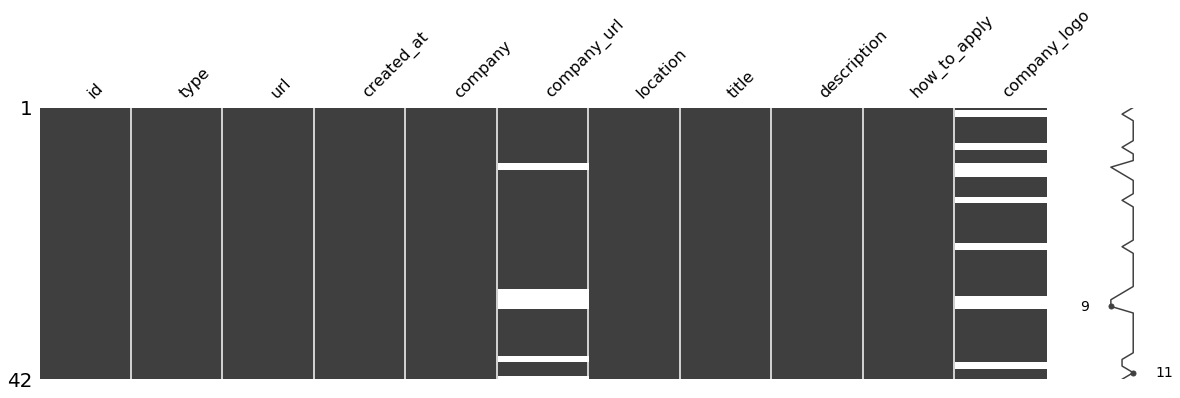

In [8]:
_ = msno.matrix(df_github, figsize=(20, 5))

In [9]:
df_indeed = load_dataset(os.path.join(data_dir, "indeed_jobs.json"))
inspect_dataset(df_indeed)

shape: (1721, 22)
columns: jobtitle, company, city, state, country, language, formattedLocation, source, date, snippet, url, onmousedown, latitude, longitude, jobkey, sponsored, expired, indeedApply, formattedLocationFull, formattedRelativeTime, stations, recommendations


,jobtitle,company,city,state,country,language,formattedLocation,source,date,snippet,...,latitude,longitude,jobkey,sponsored,expired,indeedApply,formattedLocationFull,formattedRelativeTime,stations,recommendations
count,1721,1721,1721,1721,1721,1721,1721,1721,1721,1721,...,1721.000000,1721.000000,1721,1721,1721,1721,1721,1721,1721,1721
unique,991,1100,51,5,1,1,51,830,1589,1630,...,NaN,NaN,1721,1,1,2,151,47,1,1
top,Data Engineer,"Amazon.com Services, Inc.",Chicago,IL,US,en,"Chicago, IL",Indeed,2019-09-19 22:03:35+00:00,BS OR HIGHER IN COMPUTER SCIENCE OR RELATED FI...,...,NaN,NaN,517574eca89985c2,False,False,True,"New York, NY",30+ days ago,,[]
freq,129,65,432,462,1721,1721,432,295,4,4,...,NaN,NaN,1,1721,1721,929,252,723,1721,1721
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-28 18:22:33+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-26 01:17:40+00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,41.951628,-100.057249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.448544,21.309078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.482887,-122.810580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.714270,-122.332070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


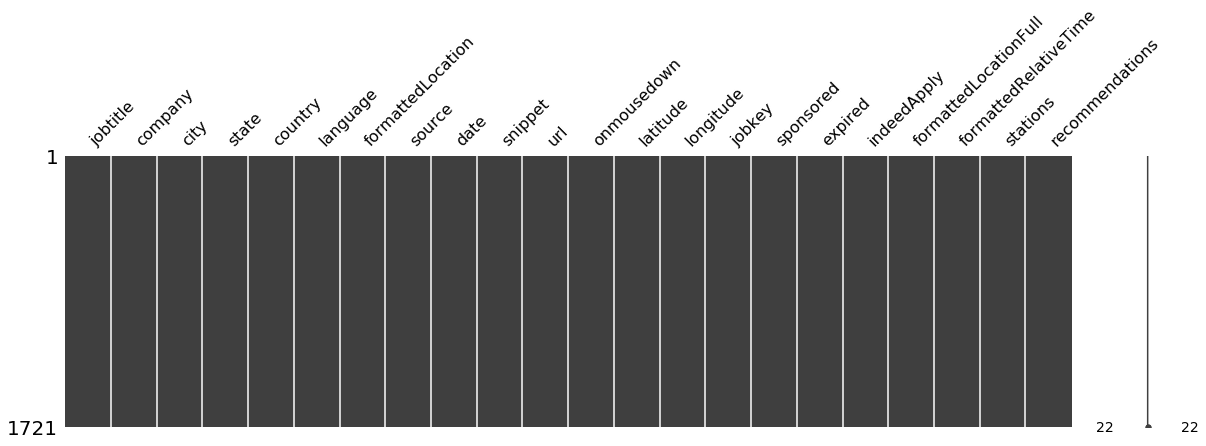

In [10]:
_ = msno.matrix(df_indeed, figsize=(20, 5))

In [11]:
df_themuse = load_dataset(os.path.join(data_dir, "themuse_jobs.json"))
inspect_dataset(df_themuse)

shape: (370, 13)
columns: contents, name, type, publication_date, short_name, model_type, id, locations, categories, levels, tags, refs, company


,contents,name,type,publication_date,short_name,model_type,id,locations,categories,levels,tags,refs,company
count,370,370,370,370,370,370,3.700000e+02,370,370,370,370,370,370
unique,339,306,2,370,362,1,NaN,26,9,8,2,370,67
top,<p>Join a team that has been partnering with o...,Summer/Intern Student,external,2018-06-27T06:39:32.208990Z,software-engineer,jobs,NaN,"[{'name': 'New York, NY'}]",[{'name': 'Engineering'}],[],[],{'landing_page': 'https://www.themuse.com/jobs...,"{'id': 850, 'short_name': 'goldmansachs', 'nam..."
freq,17,17,365,1,3,370,NaN,98,339,154,313,1,53
mean,NaN,NaN,NaN,NaN,NaN,NaN,1.849100e+06,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,4.239902e+05,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,7.712000e+03,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,1.731541e+06,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,1.992633e+06,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,2.141107e+06,NaN,NaN,NaN,NaN,NaN,NaN


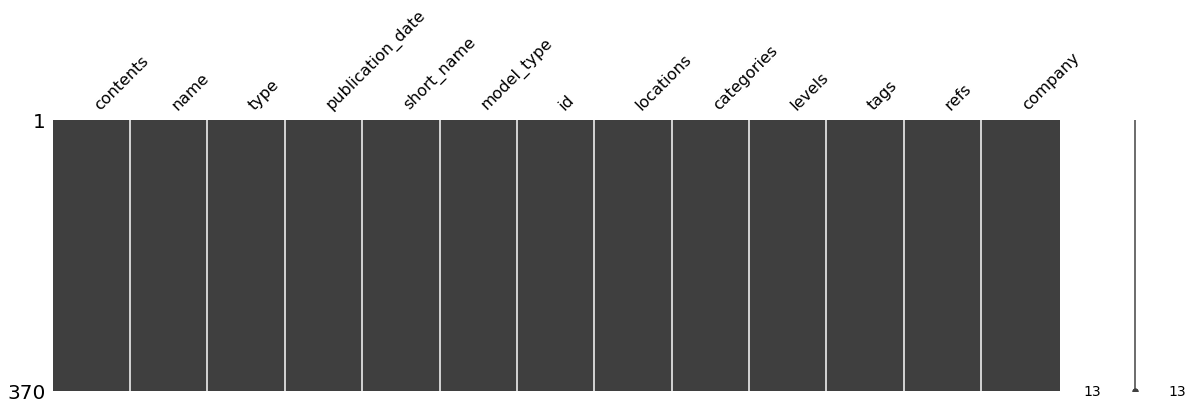

In [12]:
_ = msno.matrix(df_themuse, figsize=(20, 5))

#### munge data

In [13]:
from html.parser import HTMLParser


class _HTMLParser(HTMLParser):
    
    def __init__(self):
        super().__init__()
        self._texts = []
    
    def handle_data(self, data):
        self._texts.append(data)
        
    def get_text(self):
        return "".join(self._texts)


def extract_text_from_html(html):
    """
    Basic, stdlib-only function for extracting text data from HML.
    
    Args:
        html (str)
        
    Returns:
        str
    """
    parser = _HTMLParser()
    parser.feed(html)
    parser.close()
    return parser.get_text().strip()

In [14]:
df_themuse.loc[:, "text"] = df_themuse["contents"].map(extract_text_from_html)
df_themuse["text"]

0      Bread has a small, talented and driven enginee...
1      Consumer and Investment Management (CIMD)   Th...
2      Have you ever wondered what happens inside the...
3      The company:\n\nWe're on a mission to build th...
4      Goldman Sachs Asset Management is one of the w...
                             ...                        
365    Blue Cross Blue Shield of IL, MT, NM, OK & TX ...
366    Do you believe that creators should have the a...
367    Carrot is reinventing what fertility coverage ...
368    We're looking for a strategic leader who is pa...
369    We're looking for someone who is passionate ab...
Name: text, Length: 370, dtype: object

#### text categorization training dataset?

Below, I'm looking for key words (in context) that might be used to build up a training dataset for text categorization.

In [15]:
_ = df_themuse.loc[df_themuse["text"].str.contains("diversity"), "text"]\
    .map(lambda x: textacy.text_utils.keyword_in_context(re.sub(r"\s+", " ", x), "diversity"))

their needs—whether remote or in office. We value  diversity  and inclusivity. We are an equal opportunity empl
n. We are an equal opportunity employer and value  diversity  at our company. We do not discriminate on the bas
People Come First" is a core value and that’s why  diversity  and inclusion are vital to our priorities as an e
People Come First" is a core value and that’s why  diversity  and inclusion are vital to our priorities as an e
p. We are an equal opportunity employer and value  diversity  at our company. We do not discriminate on the bas
People Come First" is a core value and that’s why  diversity  and inclusion are vital to our priorities as an e
culture, and our commitment to equal opportunity,  diversity , and inclusiveness.You are thoughtful about all t
People Come First" is a core value and that’s why  diversity  and inclusion are vital to our priorities as an e
c. is an equal opportunity employer. We celebrate  diversity  and are committed to creating an inclusive

In [16]:
_ = df_themuse.loc[df_themuse["text"].str.contains("work[ /–-]life balance"), "text"]\
    .map(lambda x: textacy.text_utils.keyword_in_context(re.sub(r"\s+", " ", x), "work[ /–-]life balance"))

pany match • PTO, company paid holidays and great  work/life balance  • Fun and Flexible work environment that puts peo
pany match • PTO, company paid holidays and great  work/life balance  • Fun and Flexible work environment that puts peo
ompany match PTO, company paid holidays and great  work/life balance  Fun and Flexible work environment that puts peopl
olidays, paid maternity and parental leave, great  work/life balance  Fun and Flexible work environment that puts peopl


In [17]:
_ = df_themuse.loc[df_themuse["text"].str.contains("salary"), "text"]\
    .map(lambda x: textacy.text_utils.keyword_in_context(re.sub(r"\s+", " ", x), "salary"))

needs as the company scales receive a competitive  salary  and equity Your Foundations: a bachelor’s degree 
o account a woman’s longer lifespan and different  salary  curve, combined with her current financial pictur
 & Top Reasons to Work for Us: • Competitive base  salary  • Comprehensive medical, dental and vision plans 
 & Top Reasons to Work for Us: • Competitive base  salary  • Comprehensive medical, dental and vision plans 
arty SDK experience What we offer you:Competitive  salary , bonus plan, Zynga RSU's, RRSP MatchExtended Heal
ts & Top Reasons to Work for Us: Competitive base  salary  Comprehensive medical, dental and vision plans 40
ts & Top Reasons to Work for Us: Competitive base  salary  Comprehensive medical, dental and vision plans 40
r retail is a plus What can we offer? Competitive  salary  + equity Health insurance Fitness benefits 401k r
ormation into a global market leader.-Competitive  salary  and equitable compensation-Generous benefits pack
 be submitted in .p

In [18]:
_ = df_themuse.loc[df_themuse["text"].str.contains("Python"), "text"]\
    .map(lambda x: textacy.text_utils.keyword_in_context(re.sub(r"\s+", " ", x), "Python"))

ages, including JVM languages like Java or Scala;  Python ; or C++) Experience with cloud deployments (we us
ion items and deliverables About You Expertise in  Python , SQL, shell scripting, and databases. +5 years of
 Testing framework; a scripting language, such as  Python  or Bash; SQL; and Windows. Must have one (1) year
ar with relevant technologies and languages (e.g.  Python , Java, Scala, C++ and etc.). You have experience 
re libraries You have significant experience with  Python , Go, or Java                                     
mfortable doing anything and everything in modern  Python  and processing data in Unix-like systems A focus 
 their interests. Your work will cross our stack ( Python , Django, Node, PostgreSQL, React, Apollo) and wil
programming languages (Java, Javascript, C++, C#,  Python , Perl, optionally Objective-C, etc.).• Familiarit
testing tools/frameworks or scripting exploits in  Python , Perl, JavaScript, Shell scripting, etc.• Expert 
nmentsProficient wi